# Stock Price Prediction with LSTM

Adapted from "[Stock Price Prediction with PyTorch](https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632)" by Rodolfo Saldanha (original code available [here](https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch/notebook))

In [1]:
import time
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import plotly.express as px

## Import data and preprocessing

In [2]:
data = pd.read_csv('data/AMZN.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000
...,...,...,...,...,...,...,...
1254,2023-02-13,97.849998,99.680000,96.910004,99.540001,99.540001,52841500
1255,2023-02-14,98.410004,100.919998,97.519997,99.699997,99.699997,56202900
1256,2023-02-15,99.089996,101.169998,98.449997,101.160004,101.160004,48053900
1257,2023-02-16,99.209999,100.629997,98.099998,98.150002,98.150002,56339200


In [3]:
price = data[['Close']].copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price

,Close
0,-0.895797
1,-0.883591
2,-0.881564
3,-0.869283
4,-0.850895
...,...
1254,-0.458133
1255,-0.455452
1256,-0.430991
1257,-0.481422


In [4]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

## Set up LSTM

In [5]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [6]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [8]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## Train LSTM

In [9]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.40159478783607483
Epoch  1 MSE:  0.36883267760276794
Epoch  2 MSE:  0.3413291275501251
Epoch  3 MSE:  0.2966345250606537
Epoch  4 MSE:  0.20750130712985992
Epoch  5 MSE:  0.08129850775003433
Epoch  6 MSE:  0.06043578311800957
Epoch  7 MSE:  0.1135910302400589
Epoch  8 MSE:  0.06261516362428665
Epoch  9 MSE:  0.0325106717646122
Epoch  10 MSE:  0.03213058039546013
Epoch  11 MSE:  0.016267910599708557
Epoch  12 MSE:  0.01465468481183052
Epoch  13 MSE:  0.02298555336892605
Epoch  14 MSE:  0.028393415734171867
Epoch  15 MSE:  0.026833178475499153
Epoch  16 MSE:  0.020443322136998177
Epoch  17 MSE:  0.013888940215110779
Epoch  18 MSE:  0.011645639315247536
Epoch  19 MSE:  0.014845404773950577
Epoch  20 MSE:  0.019564248621463776
Epoch  21 MSE:  0.02082505263388157
Epoch  22 MSE:  0.018019307404756546
Epoch  23 MSE:  0.014207066968083382
Epoch  24 MSE:  0.012259659357368946
Epoch  25 MSE:  0.012725716456770897
Epoch  26 MSE:  0.014287871308624744
Epoch  27 MSE:  0.01529565732

In [10]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

Text(0, 0.5, 'Cost (USD)')

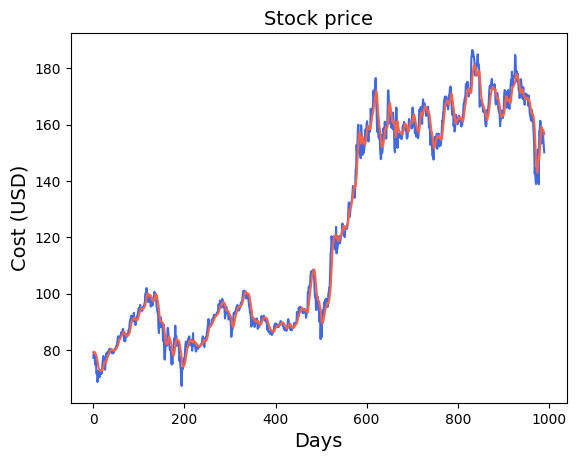

In [11]:
plt.plot(original.index, original[0], label="Data", color='royalblue')
plt.plot(predict.index, predict[0], label="Training Prediction (LSTM)", color='tomato')
plt.title('Stock price', size = 14)
plt.xlabel("Days", size = 14)
plt.ylabel("Cost (USD)", size = 14)

## Predict

In [12]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 3.54 RMSE
Test Score: 6.17 RMSE


## Results

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

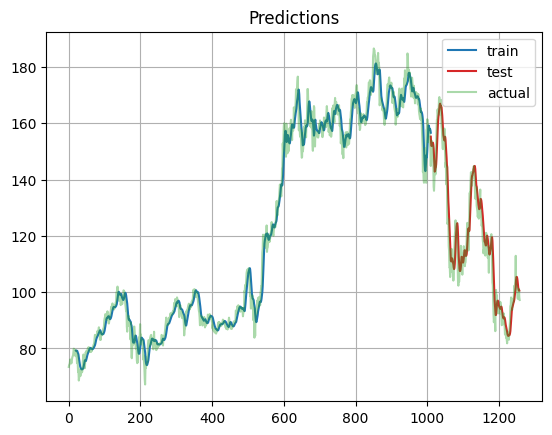

In [41]:
plt.plot(result.index, result[0], color="tab:blue", label="train")
plt.plot(result.index, result[1], color="tab:red", label="test")
plt.plot(result.index, result[2], color="tab:green", alpha=0.4, label="actual")
plt.legend()
plt.title("Predictions")
plt.grid()
plt.show()

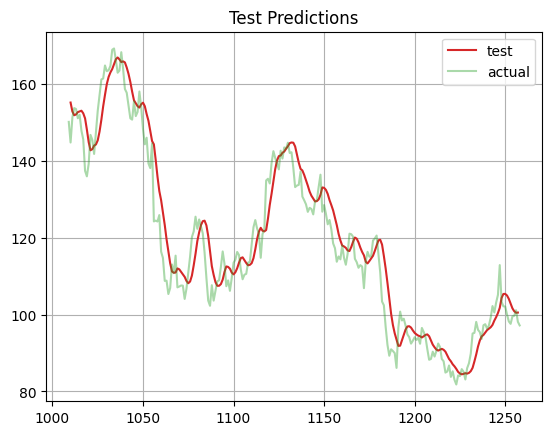

In [42]:
plt.plot(result.index[-250:], result[1][-250:], color="tab:red", label="test")
plt.plot(result.index[-250:], result[2][-250:], color="tab:green", alpha=0.4, label="actual")
plt.legend()
plt.title("Test Predictions")
plt.grid()
plt.show()

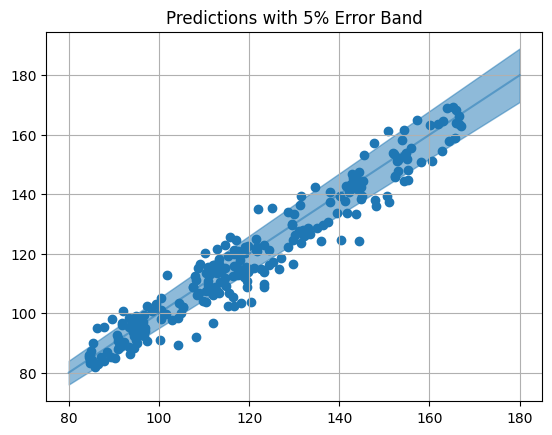

In [43]:

plt.scatter(y_test_pred, y_test)

x = np.linspace(80, 180, 300)
y = np.linspace(80, 180, 300)
error = 0.05 * x

plt.plot(x, y, alpha=0.5)
plt.fill_between(x, y-error, y+error, color="tab:blue", alpha=0.5)
plt.title("Predictions with 5% Error Band")
plt.grid()
plt.show()

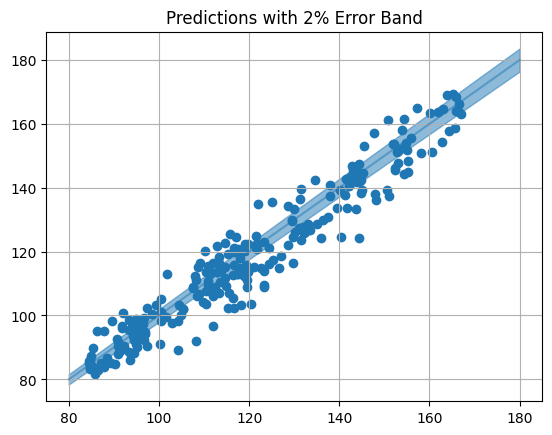

In [44]:
plt.scatter(y_test_pred, y_test)

x = np.linspace(80, 180, 300)
y = np.linspace(80, 180, 300)
error = 0.02 * x

plt.plot(x, y, alpha=0.5)
plt.fill_between(x, y-error, y+error, color="tab:blue", alpha=0.5)
plt.title("Predictions with 2% Error Band")
plt.grid()
plt.show()